# Project Presentation - Group E | Dataset: Young People Survey

In [1]:
%autosave 1


Autosaving every 1 seconds


-------------------------

In [1]:
%matplotlib inline
#!pip install CHAID
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.tree as tree
#import pydotplus
from IPython.display import Image
from os import path
from wordcloud import WordCloud
from CHAID import Tree, NominalColumn

In [2]:
responses = pd.read_csv('archive/responses.csv')
responses_pre = pd.read_csv('archive/responses.csv')
columns = pd.read_csv('archive/columns.csv')

###  About the Data

**Data Source:** https://www.kaggle.com/miroslavsabo/young-people-survey/data

**The variables can be split into the following groups:**

1. Music preferences (19 columns)
2. Movie preferences (12 columns)
3. Hobbies & interests (32 columns)
4. Phobias (10 columns)
5. Health habits (3 columns)
6. Personality traits, views on life, & opinions (57columns)
7. Spending habits (7 columns)
8. Demographics (10 columns)

The students rated from **1-5**, and **1** being the **lowest** and **5** being the **highest**

In [4]:
responses.head(2)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats


### Data Exploration

Trying to see correlation between different Music Genres.

In [5]:
music = responses.iloc[:,0:19] 
movies = responses.iloc[:,19:31] 
phobias = responses.iloc[:,63:73] 
interests = responses.iloc[:,31:63] 
health = responses.iloc[:,73:76] 
personal = responses.iloc[:, 76:133] 
demo = responses.iloc[:,140:150] 
spending = responses.iloc[:,133:140]


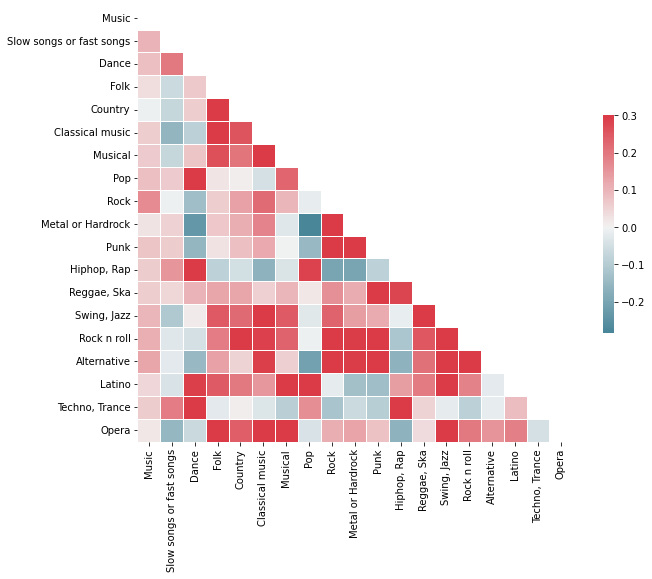

In [6]:
correlations = music.corr() 
mask = np.zeros_like(correlations, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(11, 8)) 
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
_ = sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0, 
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

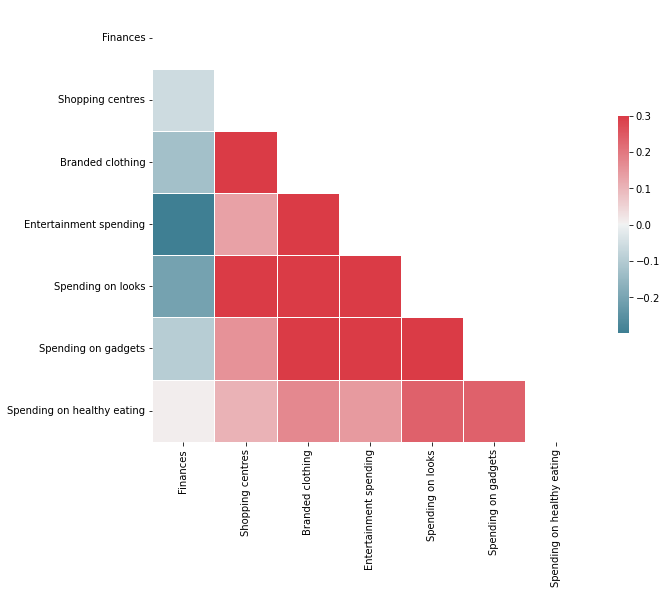

In [58]:
correlations = spending.corr() 
mask = np.zeros_like(correlations, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(11, 8)) 
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
_ = sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0, 
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

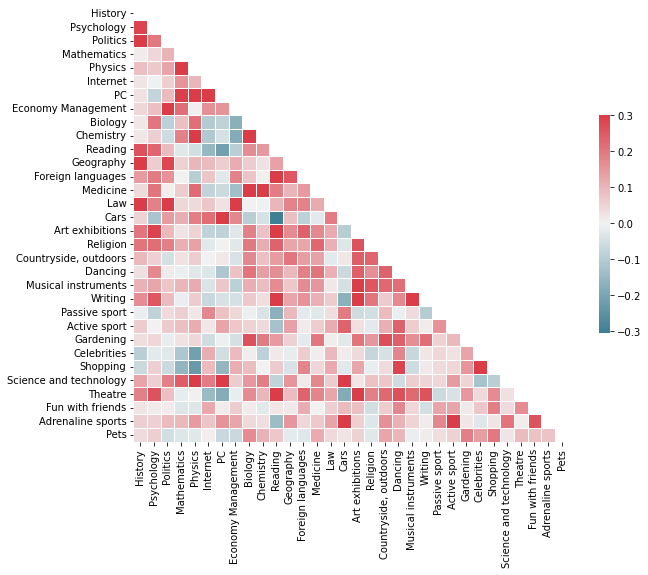

In [56]:
correlations = interests.corr() 
mask = np.zeros_like(correlations, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(11, 8)) 
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
_ = sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0, 
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can see that most of the Music Genres are highly correlated. Pop is highly correlated with Latino, Country is related with Rock n Roll

Spending habits and interests are also highly correlated. 
Those who spend on branded clothes tend to spend a lot of money in shopping centers.
Those who like cars, also like electronic gadgets and adventure sports.

#### Exploring categorical data using WordCloud

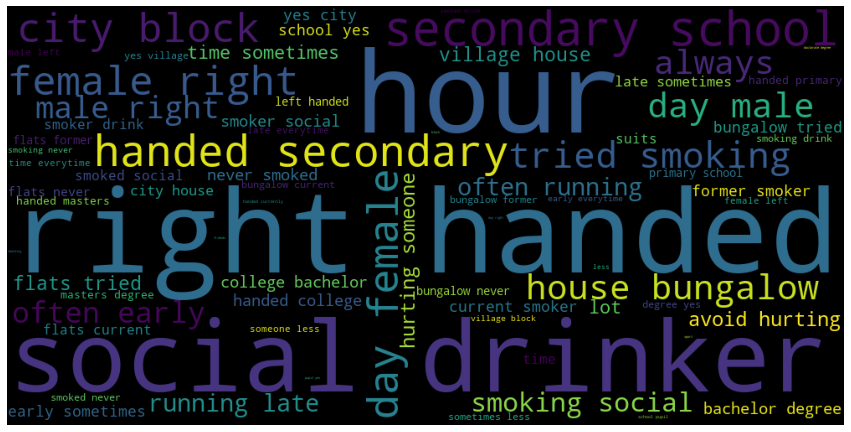

In [59]:
text = open('/Users/kshitijmahajan/Desktop/FM/archive/responses.csv').read()
wordcloud = WordCloud(width = 1000, height = 500).generate(text)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Just by looking at the above image we can say.. Right Handed, Social Drinker and Females are more in number

<AxesSubplot:xlabel='Only child', ylabel='Loneliness'>

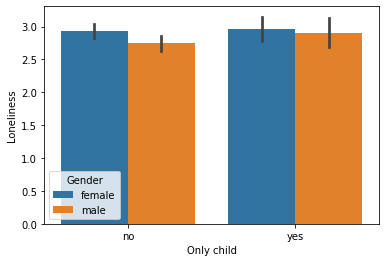

In [8]:
sns.barplot(x="Only child", y="Loneliness", hue="Gender", data=responses )

<AxesSubplot:xlabel='Left - right handed', ylabel='Life struggles'>

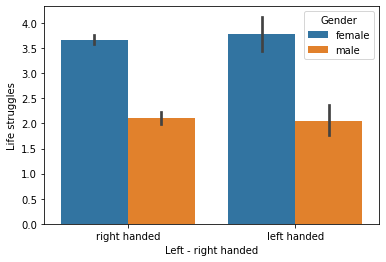

In [9]:
sns.barplot(x="Left - right handed", y="Life struggles", hue="Gender", data=responses )

<AxesSubplot:xlabel='Village - town', ylabel='Happiness in life'>

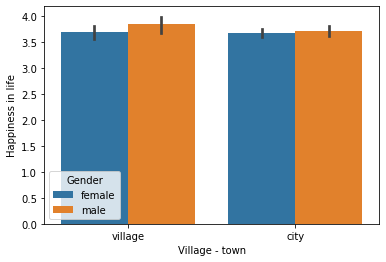

In [10]:
sns.barplot(x="Village - town", y="Happiness in life", hue="Gender", data=responses )

-------------------------

###  Data Cleaning

### Common data cleaning steps:

1. **dropna()** -  Used to drop the columns where any element is nan.
2. **Get_dummies ()**  - This helps in converting categorical variables into dummy/indicator variables



In [60]:
responses = responses.dropna()

### Data Analysis and Insights


1. Lonliness - What are the factors contributing in a person's feeling of Lonliness.
2. Life Struggles - Height and weight ? - Who is struggling more in their life.
3. Drinkers vs Non-drinkers  - Predicting based on person's choices and character traits.

### Machine Learning

To do the analysis on the above mentioned areas we used the following Machine Learning Techniques:
1. Lonliness                           - Logistic Regression
2. Life Struggles - Relationship with Height and Weight ? - Logistic Regression
3. Drinkers and Non-drinkers           - Decision Tree

## Insight 1: Loneliness

In this analysis, we are trying to use logistic regression  to check wether we can get an interesting insight related to Loneliness. Also, we would like to see which all features can be attributed towards Loneliness.

For this analysis the following steps were performed:
1. Null values were removed. This step was done as a common step at the top.
2. The dummies variables were created from the categorical variables.
3. Creating two data frames males and females for the purpose of visualising 


### Data Preparation steps:
1. **New Data Frame for Males and Females**  - This helps analyzing the 
2. **scaler.fit ()** - Standardize the data set


In [12]:
female = responses[responses.Gender == 'female']

In [13]:
male = responses[responses.Gender == 'male']

In [14]:
df1 = pd.read_csv('/Users/kshitijmahajan/Desktop/FM/archive/responses.csv')


In [15]:
responses.describe()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings
count,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,...,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000
mean,4.762611,3.295252,3.078635,2.264095,2.117211,2.982196,2.759644,3.451039,3.787834,2.354599,...,3.258160,3.026706,3.191395,3.096439,2.850148,3.514837,20.353116,173.419881,66.117211,1.299703
std,0.594699,0.795833,1.179841,1.120517,1.063888,1.244176,1.281403,1.165938,1.152979,1.396371,...,1.305537,1.305787,1.180771,1.208398,1.299140,1.076806,2.732763,9.475720,13.900289,0.992887
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,152.000000,41.000000,0.000000
25%,5.000000,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,19.000000,167.000000,55.000000,1.000000
50%,5.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,2.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,20.000000,172.000000,63.000000,1.000000
75%,5.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,5.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,21.000000,180.000000,75.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,30.000000,203.000000,150.000000,10.000000


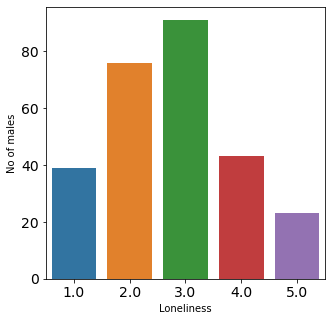

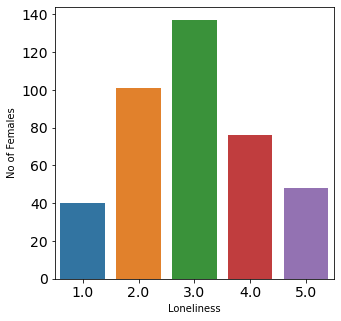

In [16]:
# Plot distribution of loneliness by gender 
# male
var_of_interest = 'Loneliness'
fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(male[var_of_interest], orient = 'h').set_ylabel("No of males") 
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=14)

# female
var_of_interest = 'Loneliness'
fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(female[var_of_interest], orient = 'h').set_ylabel("No of Females") 
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=14)

### 1. Are there any gender differences in loneliness?
<ul>
<li> The above visualization suggest that the most males & females have voted 3 on the Loneliness meter and females are in generaly more lonely than males
</ul>

In [17]:
# loneliness by whether is only child 
# subset the data into who is only child and who have siblings
onlychild = responses[responses['Only child'] == 'yes'] 
morechild = responses[responses['Only child'] == 'no'] 

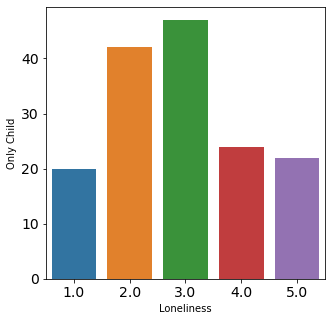

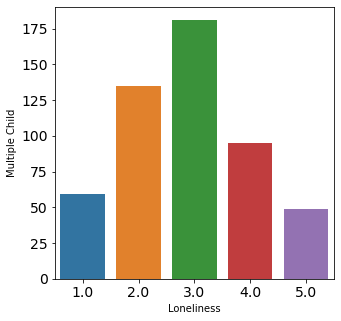

In [18]:
# count plot distribution of loneliness by child

# only child
var_of_interest = 'Loneliness'
fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(onlychild[var_of_interest], orient = 'h').set_ylabel("Only Child") 
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=14)

# more child
var_of_interest = 'Loneliness'
fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(morechild[var_of_interest], orient = 'h').set_ylabel("Multiple Child") 
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=14)




<b>2. Are people without any siblings more lonely than those who have?</b>
<ul>
<li>As we can se most children in both the categories have voted 3 on a scale of 5 for their level Loneliness
<li>Initial data exploration suggests that there’s no statistically significant difference between two groups. Thus we could not conclude that single children are more lonely than people who have siblings. 
</ul>



In [19]:
def do_ploting(x, y, figsize): #draw only 1 bar
    fig, ax = plt.subplots(figsize= figsize)
    ax.set_title("Correlation coefficient of the variables")
    sns.barplot(x=x, y=y,  ax = ax)
    ax.set_ylabel("Correlation coefficients")

In [20]:
def correlation_plot(var_of_interest, df_main, figsize = (10,30)):
    def calc_corr(var_of_interest, df, cols, figsize): #calculate correlation
        lbls = []
        vals = []
        for col in cols:
            lbls.append(col)
            vals.append(np.corrcoef(df[col], df[var_of_interest])[0,1])
        corrs = pd.DataFrame({'features': lbls, 'corr_values': vals})
        corrs = corrs.sort_values(by='corr_values')
        do_ploting(corrs.corr_values, corrs['features'], figsize)
        return corrs
    #imputing the set
    df = copy.deepcopy(df_main)
    #df.replace(mapping, inplace = True)
    mean_values = df.mean(axis=0)
    df.fillna(mean_values, inplace=True)
    
    #correlating non-categorical varibales
    cols_floats = [col for col in df.columns if df[col].dtype!='object']
    cols_floats.remove(var_of_interest)
    corrs_one = calc_corr(var_of_interest, df, cols_floats, figsize)
    
    #correlating categorical variables
    cols_cats = [col for col in df.columns if df[col].dtype=='object']
    if cols_cats:
        df_dummies = pd.get_dummies(df[cols_cats])
        cols_cats = df_dummies.columns
        df_dummies[var_of_interest] = df[var_of_interest]
        corrs_two = calc_corr(var_of_interest, df_dummies, cols_cats, (5,10))
    else:
        corrs_two = 0
    return [corrs_one, corrs_two]

### Plotting the correlation graph with Loneliness & responses

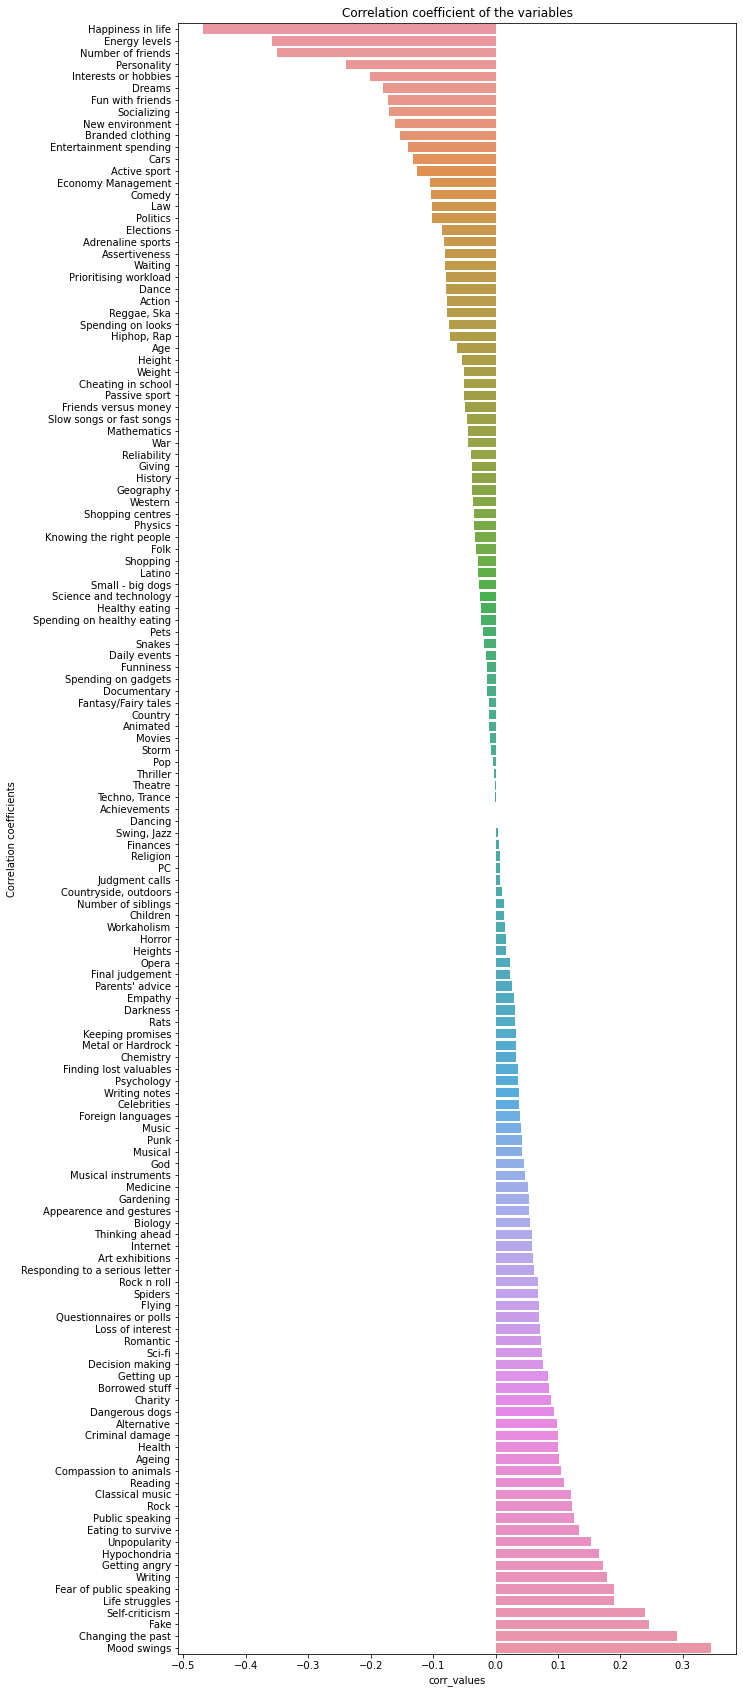

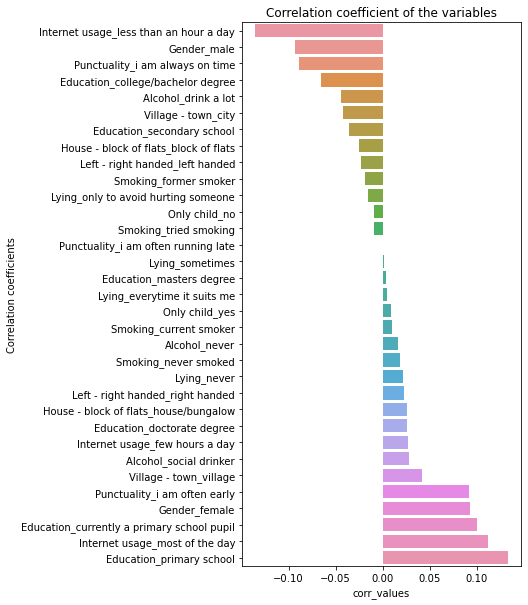

In [21]:
    
corrs_area = correlation_plot(var_of_interest, responses)


### 2. What traits are associated with loneliness?

<ul>
<li>Since numerical variables can’t be directly compared with categorical variables, we did two correlation analyses, one with numerical variables and another with categorical variables
<li>As shown above, not surprisingly, happiness, energy level and friends are negatively correlated with loneliness level.
<li>As shown above, people who rarely use internet also seem to demonstrate low loneliness level. 
<li>On the other end of the spectrum as shown above , people who have mood swings and have an education degree of primary school tend to be lonely, probably because the college students are too busy with coursework to feel lonely. 
</ul>

### Interesting Facts:
1. Relationship with **Internet**
2. How your **Education Level** can play role towards a person's loneliness.


### Machine Learning : Logistic Regression

In [22]:
mov_mus   = df1.iloc[:,[0,19]]   #movie preferences
scared    = df1.iloc[:,63:73]    #phobias
interests = df1.iloc[:,31:63]    #hobbies & interests
demo      = df1.iloc[:,140:150]  #demographics
spending  = df1.iloc[:,133:140]  #spending habits

In [23]:
print(responses.columns.get_loc('Loneliness')) 
predict   = df1.iloc[:,99]       #predict var: loneliness

99


### Joining all the vars we are using

In [24]:
df2 = mov_mus.join([scared, interests, demo, spending, predict])

In [25]:
gender  = pd.get_dummies(df2['Gender'])
handed  = pd.get_dummies(df2['Left - right handed'])
child   = pd.get_dummies(df2['Only child'])
vil_tow = pd.get_dummies(df2['Village - town'])
resid   = pd.get_dummies(df2['House - block of flats'])
educa   = pd.get_dummies(df2['Education'])

In [26]:
df2.drop(['Gender','Left - right handed','Only child','Village - town','House - block of flats','Education'], axis=1, inplace=True)
#join the dummy categorical variables:
df2 = df2.join([gender, handed, child, vil_tow, resid, educa])

In [27]:
#drop all nan
df2=df2.dropna()

In [28]:
#Instead of doing multi-label prediction, splitting Loneliness into two groups 

df2.loc[df2['Loneliness'] <= 3, 'Loneliness'] = 0
df2.loc[df2['Loneliness'] > 3, 'Loneliness'] = 1

In [29]:
#set up x & y data sets
x = df2.drop('Loneliness', axis=1)
y = df2['Loneliness']
#set up train, test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.15, random_state=115)
kf = KFold(n_splits=5)

In [30]:
#using logistic regression to predict 
logreg = LogisticRegression()
param_grid = {'C':[.01,.03,.1,.3,1,3,10]}
gs_logreg = GridSearchCV(logreg, param_grid=param_grid, cv=kf)
gs_logreg.fit(x_train, y_train)
gs_logreg.best_params_ 

{'C': 0.1}

In [31]:
#fit Logistic Regression model, eval scoring
logreg = LogisticRegression(C=.01)
logreg.fit(x_train, y_train)
print('Average accuracy score on cv (KFold) set: {:.3f}'.format(np.mean(cross_val_score(logreg, x_train, y_train, cv=kf))))
print('Accuracy score on test set is: {:.3f}'.format(logreg.score(x_test, y_test)))

Average accuracy score on cv (KFold) set: 0.713
Accuracy score on test set is: 0.706


Text(0, 0.5, 'Importance')

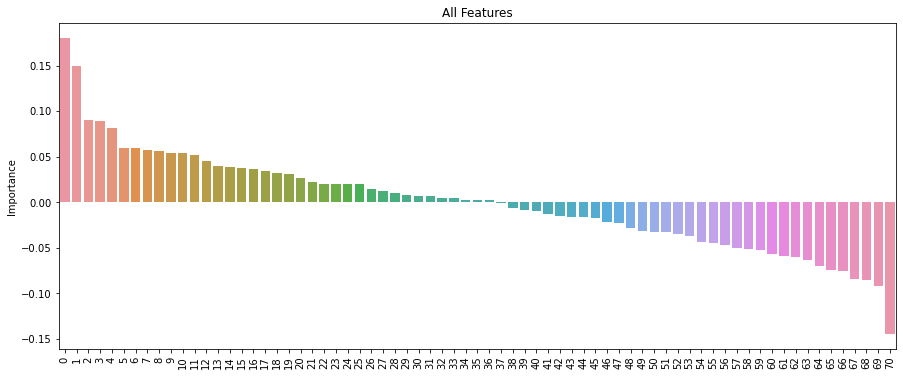

In [32]:
# put all coefficiets into a data frame & sort them.
coeff_df = pd.DataFrame(data=logreg.coef_[0], index=[x_train.columns], columns=['Feature_Import'])
coeff_df = coeff_df.sort_values(by='Feature_Import', ascending=False)
coeff_df=coeff_df.reset_index()
fig, ax1 = plt.subplots(1,1, figsize=(15,6)) 

sns.barplot(x=coeff_df.index, y=coeff_df['Feature_Import'], ax=ax1)
ax1.set_title('All Features')
ax1.set_xticklabels(labels=coeff_df.index, size=10, rotation=90) 
ax1.set_ylabel('Importance')

Text(17.200000000000003, 0.5, 'Importance')

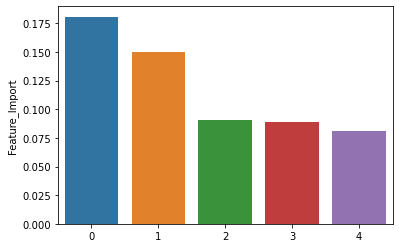

In [33]:
#fig, (ax1,ax) = plt.subplots(2,1, figsize=(15,10))
sns.barplot(x=coeff_df.index[:5], y=coeff_df['Feature_Import'].head(5))
ax1.set_title('Top Positive Features')
ax1.set_ylabel('Importance')



### 3. How to predict a young person’s loneliness?

<ul>
<li>We firstly transformed our original loneliness variable to a dummy variable. 
<li>Loneliness > 3 are considered as lonely. 
<li>Loneliness<=3 are considered not lonely. 
<li>Using our logistic regression model with 71 variables, we can predict a person’s loneliness level 
at an accuracy rate of 71% with (K-fold) test sets. 
<li>The variables with largest coefficients can be found in above figure. 
<li>Pepople who like writing, have fear of public speaking, surfs a lot on internet,enjoys using PC & spends a lot on gadgets can have <b>high</b> degree of Loneliness whereas if they like spending time with friends, likes active sports, geography, pets & entertainment are <b>negatively </b>related with Loneliness
</ul>


---------

## Insight 2: Life Struggles - Relationship with Height and Weight

In this analysis, we are trying to use logistic regression to check wether we can get an interesting insight related to Life Struggles. 

Also, we would like to see which all features can be attributed towards Life struggles.

For this analysis the following steps were performed:

1. Null values were removed. This step was done as a common step at the top.

2. The dummies variables were created from the categorical variables.

3. Finding the highest correlations.

4. Trying to find the reasons behind those correlations.

### Data Preparation steps:
1. **Get_dummies ()**  - This helps in converting categorical variables into dummy/indicator variables
2. **scaler.fit ()** - Standardize the data set


In [34]:
responses4 = pd.get_dummies(columns=['Smoking', 'Punctuality', 'Lying','Alcohol',
                                     'Internet usage', 'Left - right handed', 'Education', 'Only child', 'Village - town', 'House - block of flats'],data=responses)

### To get insights:
3. Finding top correlation for the analysis
4. Performed logistic regression to find out the negative correlation between - "Life Struggles" and "Height" / "Weight"

In [35]:
corr = responses.corr()

os = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
os.head(10)

Height               Weight              0.729430
Biology              Medicine            0.719063
Fantasy/Fairy tales  Animated            0.709269
Biology              Chemistry           0.679350
Shopping             Shopping centres    0.658652
Mathematics          Physics             0.611750
Chemistry            Medicine            0.602294
Classical music      Opera               0.599296
Art exhibitions      Theatre             0.567726
Snakes               Rats                0.565762
dtype: float64

In [36]:
os.tail(10)

Reading            Cars                -0.323793
Shopping           Height              -0.330223
Romantic           Height              -0.335372
Loneliness         Number of friends   -0.349509
Changing the past  Happiness in life   -0.350884
Loneliness         Energy levels       -0.358408
Dangerous dogs     Small - big dogs    -0.385346
Life struggles     Weight              -0.392175
                   Height              -0.409165
Loneliness         Happiness in life   -0.467836
dtype: float64

The most correlated features are Height and Weight which are self-explanaroty. People who are interested in Biology are also interested in Medicine and Chemistry. The same for Fantasy/Fairy tales and Animated movies.

You might ask why there is a negative correlation between Life struggles, Weight and Height. Let's explore further to understand the reasons behind this correlation.

If we observe the correlations of Life struggles, and hight and weight, we will see that these three variables are highly correlated with gender

In [37]:
#Correlation between height, weight and gender
responses5 = responses4.corr()
responses5.iloc[136:138, 156:158]

,Left - right handed_left handed,Left - right handed_right handed
Height,0.064352,-0.064352
Weight,0.047930,-0.047930


In [38]:
#Correlation between life struggles and gender
responses5.iloc[118:119, 156:158]

,Left - right handed_left handed,Left - right handed_right handed
Life struggles,0.007951,-0.007951


Logistic regression will provide us more insights on this

In [39]:
insight2 = responses4.dropna(subset=['Gender'])
features_int = [col for col in insight2.columns if insight2[col].dtype!='object']
X = insight2[features_int]
mean_values = X.mean(axis=0)
X = X.apply(lambda x: x.fillna(x.mean()),axis=0)
Y = responses4['Gender']
Y.replace('female',0, inplace = True)
Y.replace('male',1, inplace = True)

In [40]:
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

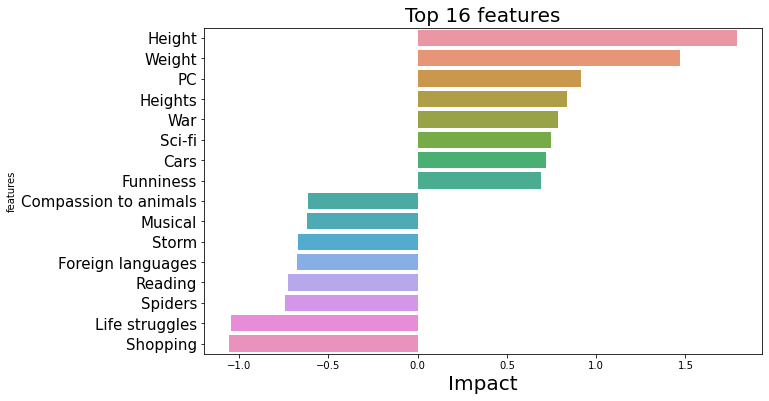

In [41]:
clr = LogisticRegression()
clr.fit(X, Y)
feat_coeff = pd.DataFrame({'features': features_int,'impacts': clr.coef_[0]})
feat_coeff = feat_coeff.sort_values('impacts', ascending=False)

top10 = pd.concat([feat_coeff.head(8),feat_coeff.tail(8)])
fig, ax1 = plt.subplots(1,1, figsize=(10,6))
_ = sns.barplot(y=top10.features, x=top10.impacts, ax=ax1)
_ = ax1.set_title('Top 16 features', size=20)
_ = ax1.set_yticklabels(labels=top10.features, size=15)
_ = ax1.set_xlabel('Impact', size=20)

If you have more life struggles in life, you are probably a woman :) Of course, if you like shopping, you are more likely to be a woman. But if you are tall, or weigh a lot or like "PC Software, Hardware" then you are probably a man.

Negative correlation between Life struggles and height/weight was due to the female and male separation.

## Insight 3: Drinkers and Non-drinkers

In this analysis, we are tried a decision tree as a machine learning technique to check wether we can get an interesting insight or not related to drinkers and non-drinkers.

For this analysis the following steps were performed:
1. Null values were removed. This step was done as a common step at the top.
2. The dummies variables were created from the categorical variables.
3. A function is written to replace the string with numbers in the field Alcohol and store it in a new column Alcohol2.
4. A decision tree with depth 3 was created.


In [42]:
insight3 = responses

In [43]:
insight3 = pd.get_dummies(columns=['Smoking', 'Punctuality', 'Lying',
                           'Internet usage', 'Gender', 'Left - right handed', 'Education', 'Only child', 'Village - town', 'House - block of flats'],data=insight3)

In [44]:
def JNum(Job_String):
    if Job_String == 'never':
        return 0
    elif Job_String == 'social drinker':
        return 1
    else:
        return 2

In [45]:
insight3['Alcohol2'] = insight3['Alcohol'].apply(JNum)

In [46]:
X = insight3.drop(['Alcohol2','Alcohol'],axis=1)

In [47]:
Y = insight3['Alcohol2']

In [48]:
dt = tree.DecisionTreeClassifier(max_depth=3)

In [49]:
dt.fit(X,Y)

DecisionTreeClassifier(max_depth=3)

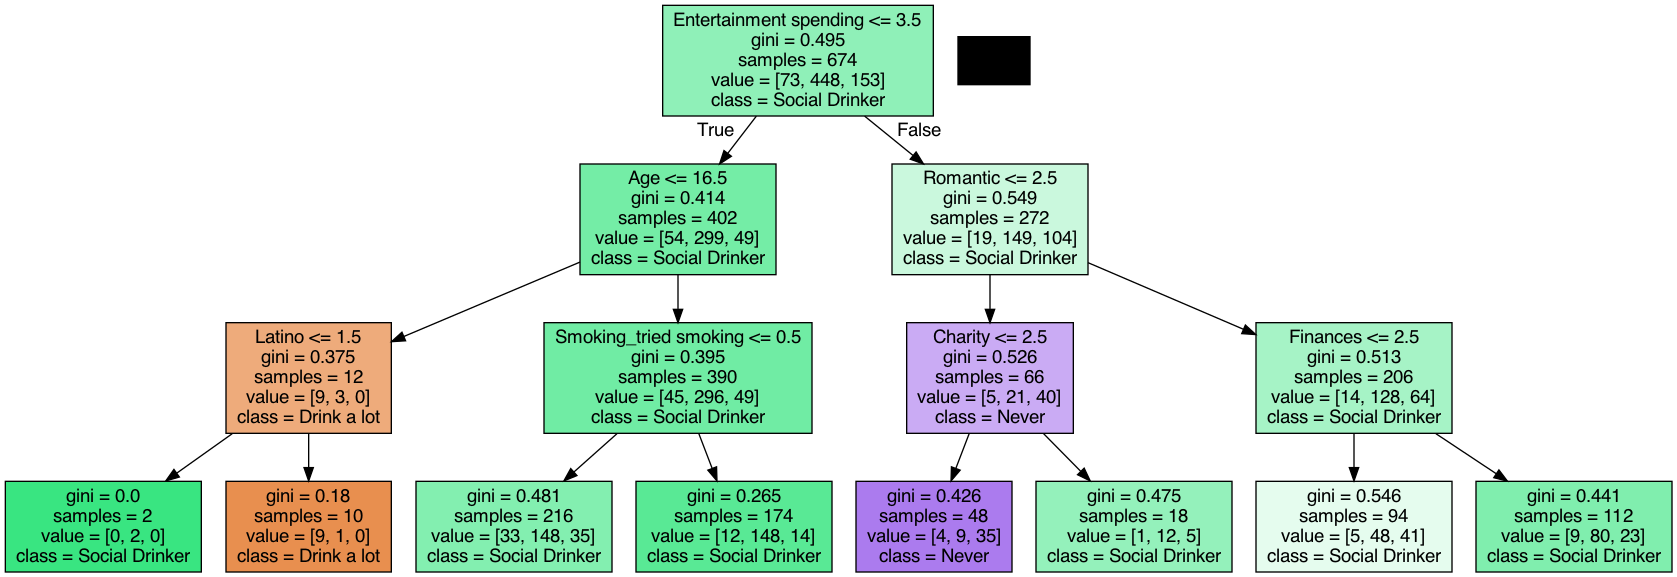

In [50]:
!pip install graphviz
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names= dt_feature_names, 
    class_names = [  'Social Drinker' if i == 1 else  'Never' if i == 2 else 'Drink a lot' for i in dt.classes_],
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

# What Marketing decisions can we take based on this insights?
# Need your help to build on these pointers.
**Loneliness:** 
Entertainment companies and travel agencies can target these groups as lonely youngsters are likely to spend their time and money on entertainment, travelling, and adventure sport. The Co-op Foundations and charitable organizations working to prevent and tackle youth loneliness can take these factors into consideration to help young people form stronger connections within their community. 

### Couldn't think much on this topic. Don't know why I analysed this.
**Life Struggles:** Please take care of females.It is the moral responsibility of everyone to treat women with respect and dignity as they already have a lot of struggles.

**Drinkers vs Non-drinkers:** It was surprising to find that teenagers of age 15-16 tend to drink more even though they are not legally allowed to do so. Underage drinking is a serious public health problem in the society. According to a study, Britain has the fourth highest levels of underage drinking among 15-years-olds. Parents and public welfare organizations can work together to fight this issue by focusing on the factors in the above analysis.
Alcohol companies need to come up with other profitable alternatives that are legal for teenagers and not hazardous to health.


### Additional Analysis:  Analysis before finalizing the above models.

In [51]:
#%%
from scipy import stats 
#-----------------------hypothesis testing-----------------------------
def check_values_in_variable(variable):
    uniquevalues= responses[variable].unique()
    return uniquevalues
#Check the unique values in a variable, return the values as a list

def divide_groups(groupingvar):
    uniquevalues = check_values_in_variable(groupingvar)
    groups=[]
    for value in uniquevalues:
        groups.append(responses.groupby([groupingvar]).get_group(value))
    return groups

In [52]:
#Divide the dataset by the grouping variable, using the unique values list
#returned by the above function       
        
def hypothesis_test(groupingvar,interestvar):
    uniquevalues = check_values_in_variable(groupingvar) #get unique values
    groups=[]
    groupnames=[]
    varlists=[]
    results=[]
    for value in uniquevalues: #append all the unique values to a groupname list
        groups.append(responses.groupby([groupingvar]).get_group(value))
        groupnames.append(value)
    for group in groups: #append all the values of **variable of interest**
        varlists.append(group[interestvar]) #to the list
    for var1 in varlists: #conduct the t-test, append all p-values of comparing the values
        for var2 in varlists:
            if (var1 is var2):
                continue
            else:
                results.append(stats.ttest_ind(var1,var2))
    for i in range(len(groupnames)): #display the p-values
        for j in range(len(groupnames)):
                if groupnames[i] is groupnames[j]:
                    continue
                else:
                    print('Compare '+ str(interestvar) + ' of ' + str(groupnames[i])+' and '+str(groupnames[j])+":\n")       
                    print(str(results[i]) + ":\n")
    return results[0] #For testing

In [53]:
# -----  heat map plot distribution of loneliness -------
col = 'Loneliness'
corr = responses.corr() #find correlations

<AxesSubplot:>

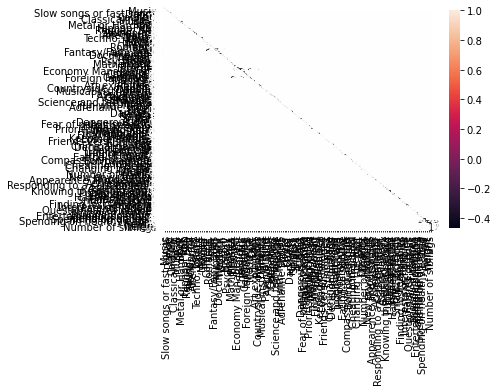

In [54]:
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True)

### CHAID

In [3]:
## set the CHAID input parameters
independent_variable_columns = columns[columns['short'] != 'Spending on healthy eating']['short']
dep_variable = 'Spending on healthy eating'

In [4]:
## create the Tree via pandas
tree = Tree.from_pandas_df(responses, dict(zip(independent_variable_columns, ['nominal'] * 3)), dep_variable)

In [5]:
tree.print_tree()

([], {1.0: 41.0, 2.0: 132.0, 3.0: 282.0, 4.0: 330.0, 5.0: 223.0, '<missing>': 2.0}, (Slow songs or fast songs, p=5.144510389629496e-07, score=37.32934460817271, groups=[['<missing>', 3.0, 4.0, 2.0], [1.0, 5.0]]), dof=5))
|-- (['<missing>', 3.0, 4.0, 2.0], {1.0: 28.0, 2.0: 111.0, 3.0: 253.0, 4.0: 309.0, 5.0: 180.0, '<missing>': 2.0}, <Invalid Chaid Split> - p-value greater than alpha merge)
+-- ([1.0, 5.0], {1.0: 13.0, 2.0: 21.0, 3.0: 29.0, 4.0: 21.0, 5.0: 43.0, '<missing>': 0}, <Invalid Chaid Split> - p-value greater than alpha merge)



In [6]:
tree.to_tree()

In [7]:
first_node = tree.tree_store[0]

In [8]:
first_node

([], {1.0: 41.0, 2.0: 132.0, 3.0: 282.0, 4.0: 330.0, 5.0: 223.0, '<missing>': 2.0}, (Slow songs or fast songs, p=5.144510389629496e-07, score=37.32934460817271, groups=[['<missing>', 3.0, 4.0, 2.0], [1.0, 5.0]]), dof=5))

In [9]:
first_node.members

{1.0: 41.0, 2.0: 132.0, 3.0: 282.0, 4.0: 330.0, 5.0: 223.0, '<missing>': 2.0}

In [10]:
first_node.split.p

5.144510389629496e-07

In [11]:
first_node.split.score

37.32934460817271

In [19]:
import os

tree.render(path = "/Users/dishagandhi/opt/anaconda3/lib/python3.9/site-packages/blah.png",view=True)
#tree.show()

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [15]:
!pip install graphviz

In [33]:
import kaleido
import plotly
import plotly.graph_objects as go
#!pip install --upgrade "kaleido==0.1.*"

In [ ]:
>>> tree.print_tree()
([], {1: 5, 2: 5}, ('a', p=0.001565402258, score=10.0, groups=[[1], [2]]), dof=1))
├── ([1], {1: 5, 2: 0}, <Invalid Chaid Split>)
└── ([2], {1: 0, 2: 5}, <Invalid Chaid Split>)

## to get a LibTree object,
>>> tree.to_tree()
<treelib.tree.Tree object at 0x114e2e350>

## the different nodes of the tree can be accessed like
first_node = tree.tree_store[0]

>>> first_node
([], {1: 5, 2: 5}, ('a', p=0.001565402258, score=10.0, groups=[[1], [2]]), dof=1))

## the properties of the node can be access like
>>> first_node.members
{1: 5, 2: 5}

## the properties of split can be accessed like
>>> first_node.split.p
0.001565402258002549
>>> first_node.split.score
10.0